In [201]:
import pandas as pd
import numpy as np
import datetime
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_excel("wt_cellcycle_durations.xlsx", header=None)

# assign column names and set index
df_raw.columns = ['Division'] + list(range(1, df_raw.shape[1]))
df_raw.set_index('Division', inplace=True)

# convert to hours
def value_to_hours(val):
    if pd.isna(val):
        return np.nan

    # datetime.datetime or pandas Timestamp
    if isinstance(val, (datetime.datetime, pd.Timestamp)):
        return val.hour + val.minute / 60 + val.second / 3600

    # excel sometimes uses datetime.time
    if isinstance(val, datetime.time):
        return val.hour + val.minute / 60 + val.second / 3600

    # excel may store durations as fraction of a day
    if isinstance(val, (float, int)) and 0 <= val < 1:
        return val * 24

    return np.nan

df_hours = df_raw.applymap(value_to_hours)

# clean index — extract digits from labels
# reset_index() gives us "Division" as a column
df_hours = df_hours.reset_index()

# extract the number from "Div 1", "Div2", etc.
df_hours["Division Number"] = df_hours["Division"].str.extract(r"(\d+)")[0].astype(float)

# set cleaned index
df_hours = df_hours.set_index("Division Number")
df_hours = df_hours.drop(columns=["Division"])


/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/834135726.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hours = df_raw.applymap(value_to_hours)


In [202]:
df_hours

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Division Number,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,4.733333,4.866667,2.700000,1.966667,2.400000,1.333333,2.000000,2.250000,1.916667,2.583333,...,1.416667,0.916667,1.416667,1.083333,1.750000,2.666667,0.916667,1.083333,0.750000,4.000000
2.0,5.600000,5.333333,3.333333,2.000000,2.733333,1.833333,2.500000,1.916667,1.916667,3.083333,...,1.750000,1.000000,1.583333,1.166667,2.166667,2.916667,1.000000,1.500000,0.916667,3.583333
3.0,NaN,NaN,3.966667,2.266667,3.000000,2.333333,3.083333,1.916667,2.083333,3.666667,...,2.333333,1.083333,1.916667,1.250000,2.333333,3.416667,1.333333,1.916667,1.166667,NaN
4.0,NaN,NaN,NaN,2.700000,NaN,2.750000,NaN,NaN,1.916667,NaN,...,2.916667,1.166667,2.000000,1.250000,2.750000,3.666667,1.250000,2.333333,1.333333,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.666667,1.166667,2.333333,1.166667,3.083333,NaN,1.416667,2.750000,1.416667,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.083333,2.500000,1.083333,NaN,NaN,1.750000,NaN,1.500000,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.250000,3.083333,1.333333,NaN,NaN,2.000000,NaN,1.750000,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.166667,NaN,1.333333,NaN,NaN,2.666667,NaN,NaN,NaN


In [204]:
# compute mean and standard deviation for each division
mean_durations = df_hours.mean(axis=1)
std_durations = df_hours.std(axis=1)
summary = pd.DataFrame({
    "Mean Duration (hrs)": mean_durations,
    "Std Dev (hrs)": std_durations
})

print(summary)

                 Mean Duration (hrs)  Std Dev (hrs)
Division Number                                    
NaN                              NaN            NaN
1.0                         2.016667       1.135619
2.0                         2.276667       1.249435
3.0                         2.298485       0.961383
4.0                         2.241667       0.974679
5.0                         2.068182       0.839823
6.0                         1.864583       0.742606
7.0                         1.805556       0.686510
8.0                         1.729167       0.671424
9.0                         1.666667       0.416667


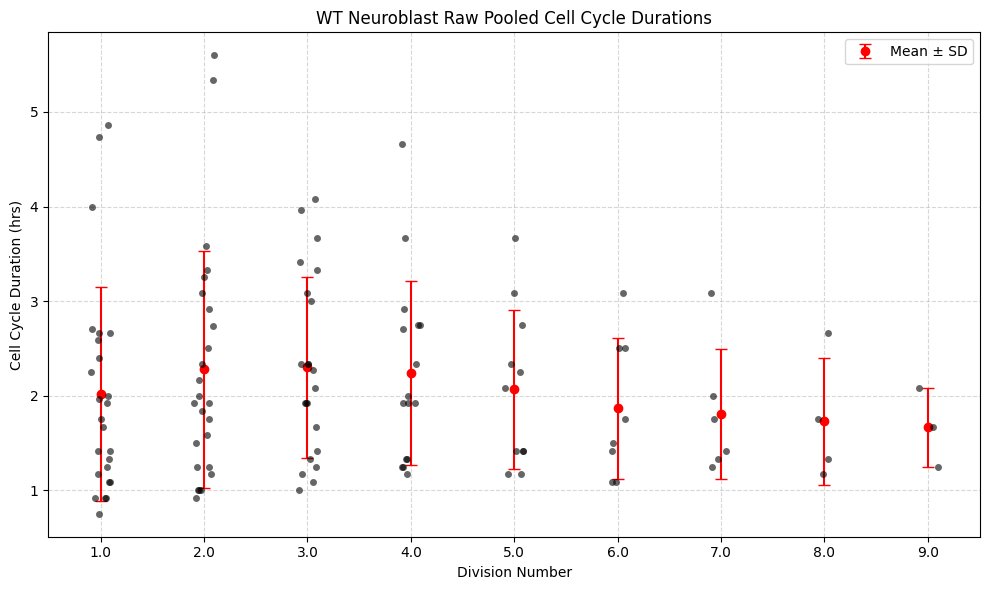

In [205]:
# melt the wide-format DataFrame to long format
df_long = df_hours.reset_index().melt(id_vars="Division Number",
                                      var_name="Cell",
                                      value_name="Duration (hrs)")
df_long = df_long.dropna()

# compute summary stats
summary = df_long.groupby("Division Number")["Duration (hrs)"].agg(["mean", "std"])

# get the unique division numbers in the order Seaborn will plot them
division_order = sorted(df_long["Division Number"].unique())

# map division numbers to their categorical x positions
x_positions = list(range(len(division_order)))
mean_values = summary.loc[division_order, "mean"]
std_values = summary.loc[division_order, "std"]


plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long, x="Division Number", y="Duration (hrs)",
              jitter=True, alpha=0.6, color='black', order=division_order)
plt.errorbar(x_positions, mean_values, yerr=std_values,
             fmt='o', color='red', capsize=4, label="Mean ± SD")

# final plot setup
plt.title("WT Neuroblast Raw Pooled Cell Cycle Durations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Division Number")
plt.ylabel("Cell Cycle Duration (hrs)")
plt.legend()
plt.tight_layout()
plt.show()

In [207]:
# need to normalize to first division time
df_norm = df_hours.copy()
for cell in df_norm.columns:
    first_div = df_norm[cell].dropna().iloc[0]
    df_norm[cell] = df_norm[cell] / first_div

mean_durations = df_norm.mean(axis=1)
std_durations = df_norm.std(axis=1)
summary = pd.DataFrame({
    "Mean Duration (hrs)": mean_durations,
    "Std Dev (hrs)": std_durations
})

print(summary)


                 Mean Duration (hrs)  Std Dev (hrs)
Division Number                                    
NaN                              NaN            NaN
1.0                         1.000000       0.000000
2.0                         1.142683       0.138052
3.0                         1.382767       0.266242
4.0                         1.625310       0.453170
5.0                         1.768257       0.460320
6.0                         1.751324       0.490354
7.0                         1.805247       0.479797
8.0                         1.830420       0.783225
9.0                         1.724942       0.482382


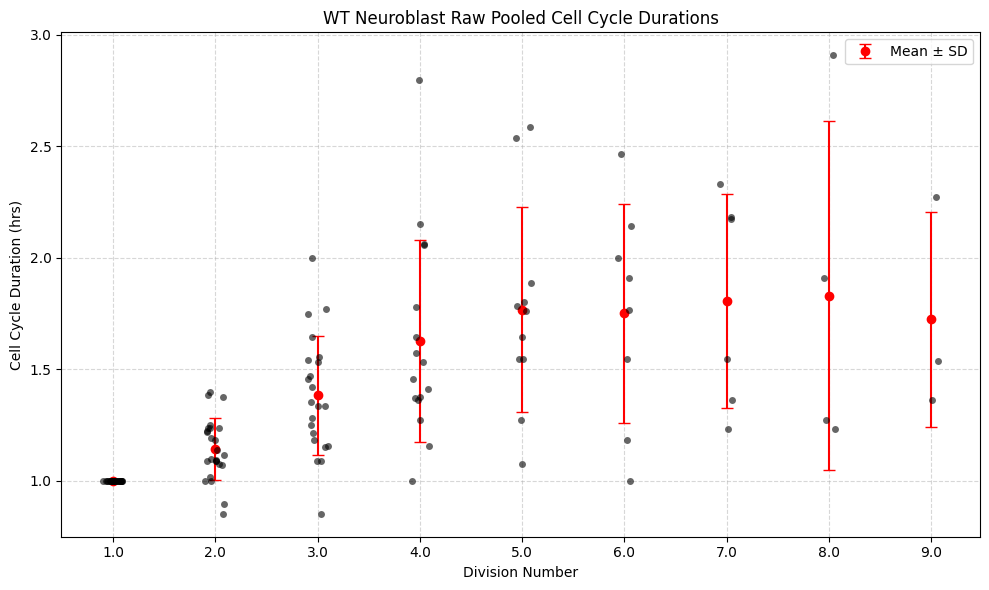

In [208]:
df_long = df_norm.reset_index().melt(id_vars="Division Number", 
                                      var_name="Cell", 
                                      value_name="Duration (hrs)")
df_long = df_long.dropna()

summary = df_long.groupby("Division Number")["Duration (hrs)"].agg(["mean", "std"])

division_order = sorted(df_long["Division Number"].unique())

x_positions = list(range(len(division_order)))
mean_values = summary.loc[division_order, "mean"]
std_values = summary.loc[division_order, "std"]

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long, x="Division Number", y="Duration (hrs)",
              jitter=True, alpha=0.6, color='black', order=division_order)
plt.errorbar(x_positions, mean_values, yerr=std_values,
             fmt='o', color='red', capsize=4, label="Mean ± SD")

plt.title("WT Neuroblast Raw Pooled Cell Cycle Durations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Division Number")
plt.ylabel("Cell Cycle Duration (hrs)")
plt.legend()
plt.tight_layout()
plt.show()

In [170]:
# Candidate functions
def linear(x, a, b):
    return a * x + b

def logarithmic(x, a, b):
    return a * np.log(x) + b

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# R² scoring
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

Fit models to each cell's profile individually

In [209]:
from collections import defaultdict

per_cell_fit_results = defaultdict(dict)

for cell in df_norm.columns:
    y = df_norm[cell].dropna()
    x = y.index.astype(float)
    y = y.values

    if len(x) >= 3: # enough points to fit 2 parameter models without default R^2 being 1
        for model_name, func in [("Linear", linear), ("Logarithmic", logarithmic)]:
                try:
                    params, _ = curve_fit(func, x, y)
                    y_pred = func(x, *params)
                    r2 = r_squared(y, y_pred)
                    per_cell_fit_results[model_name][cell] = {
                        "params": params,
                        "r2": r2
                    }
                    continue
                except:
                    continue

    if len(x) >=4: # enough points to fit quadratic, exponential decay, and cubic
        for model_name, func in [("Quadratic", quadratic), ("Exponential Decay", exponential_decay), ("Cubic", cubic)]:
            try:
                params, _ = curve_fit(func, x, y)
                y_pred = func(x, *params)
                r2 = r_squared(y, y_pred)
                per_cell_fit_results[model_name][cell] = {
                    "params": params,
                    "r2": r2
                }
            except:
                continue

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096

No fitted models for cell 1, too few points
No fitted models for cell 2, too few points


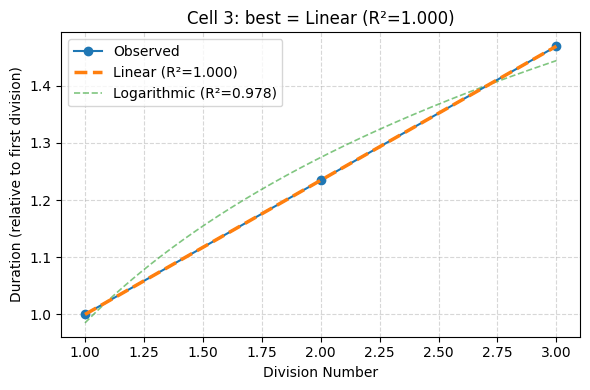

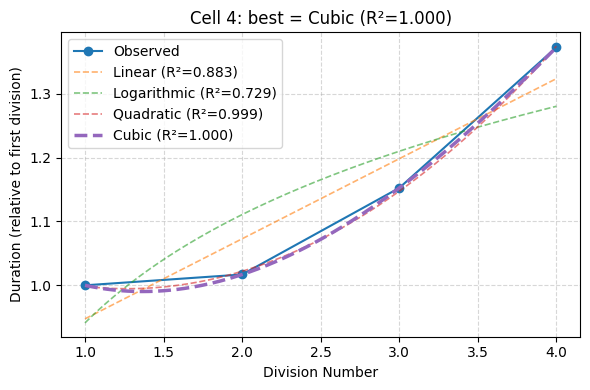

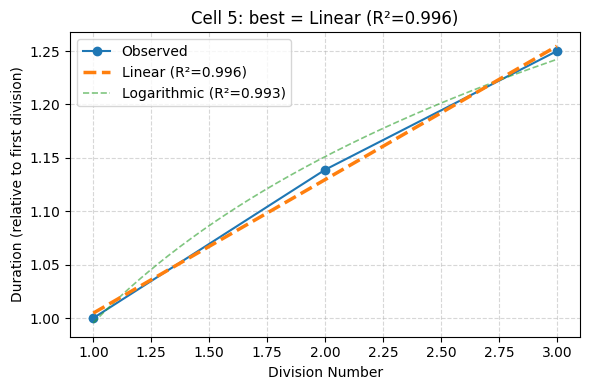

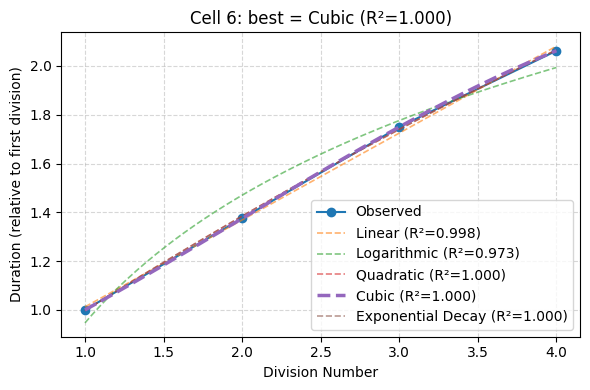

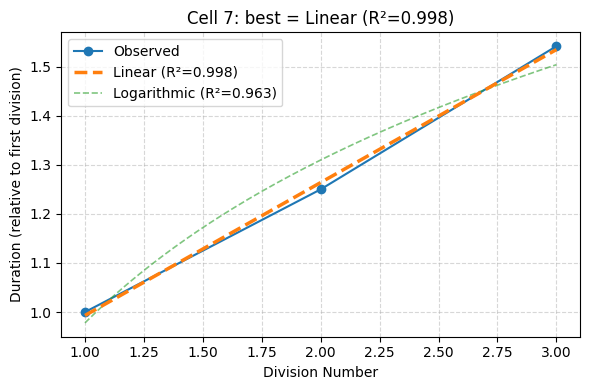

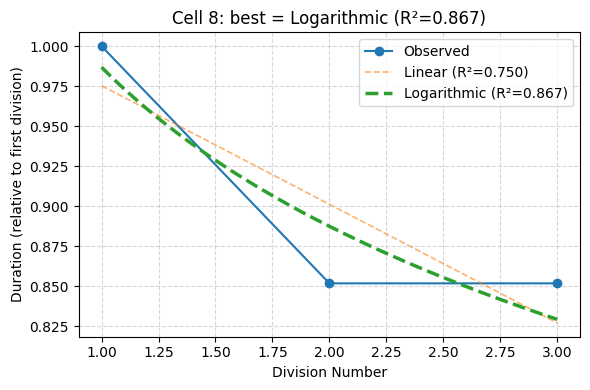

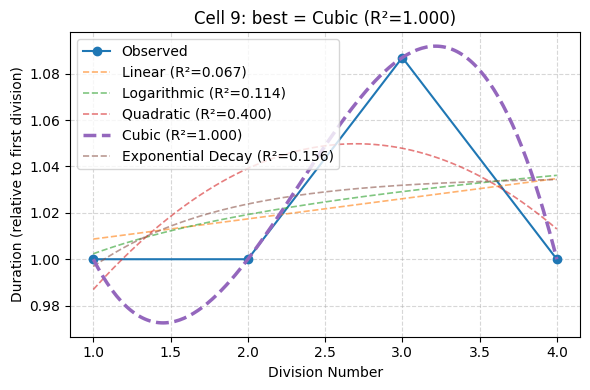

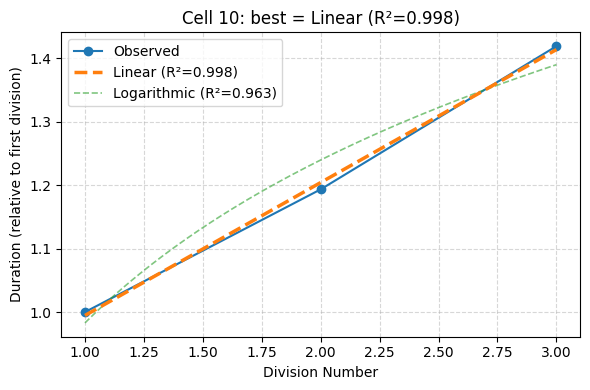

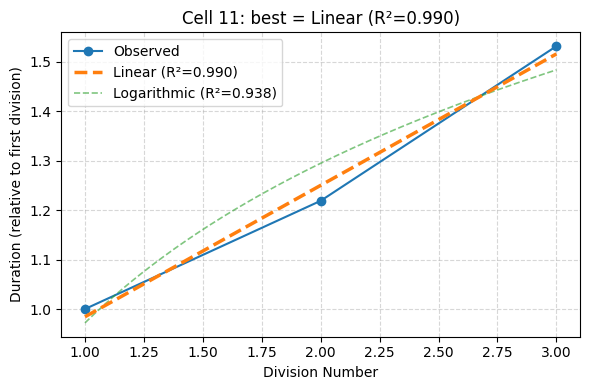

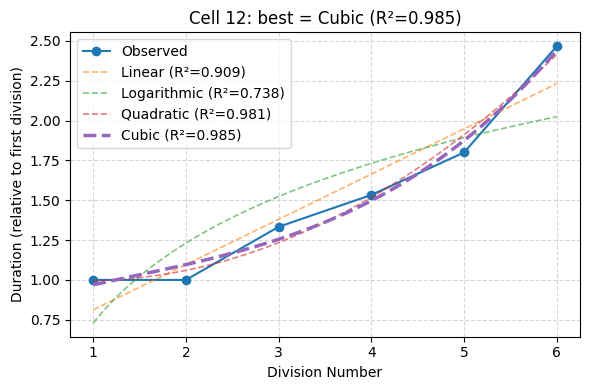

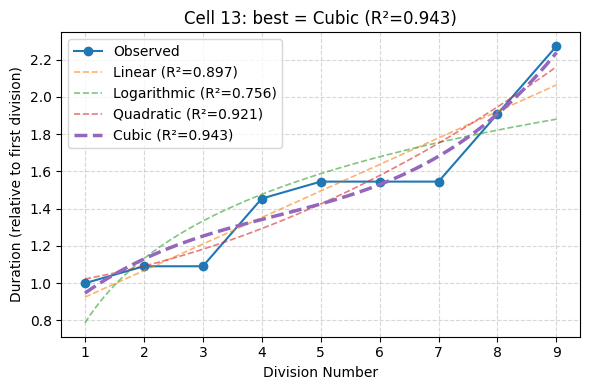

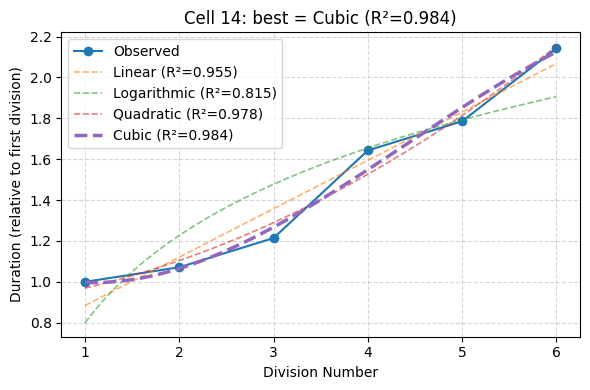

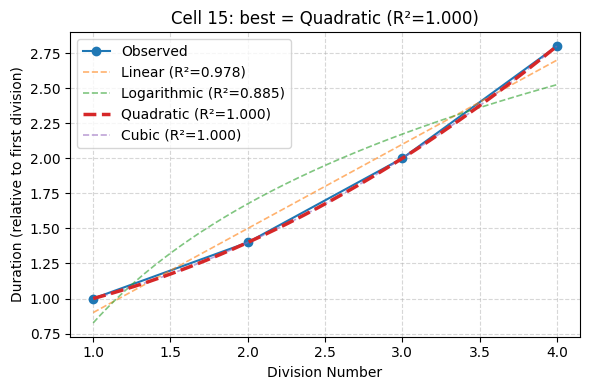

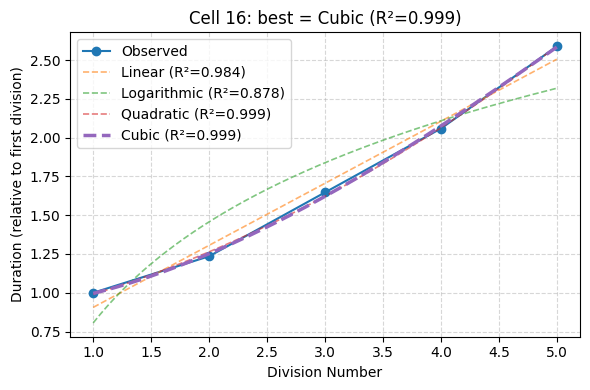

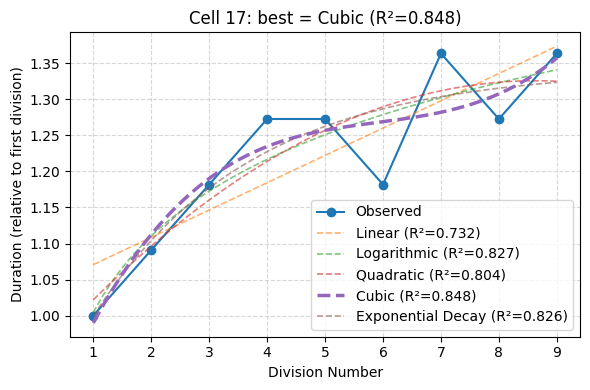

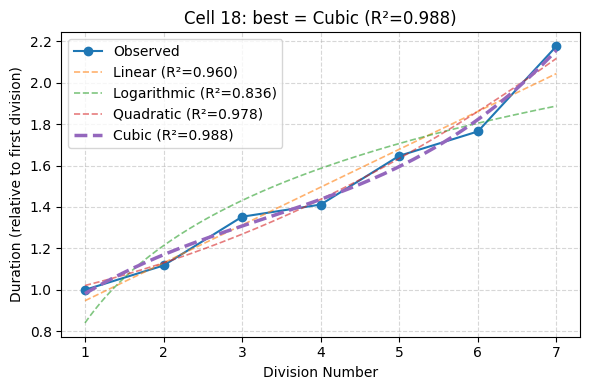

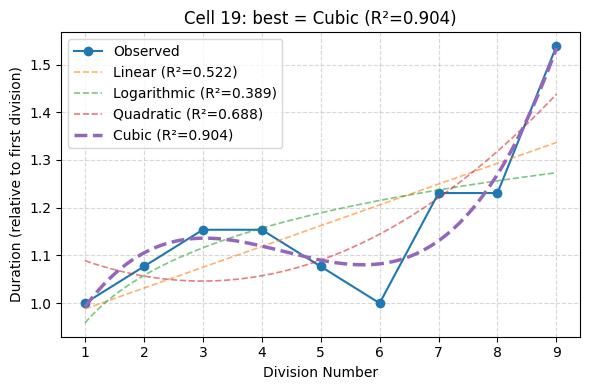

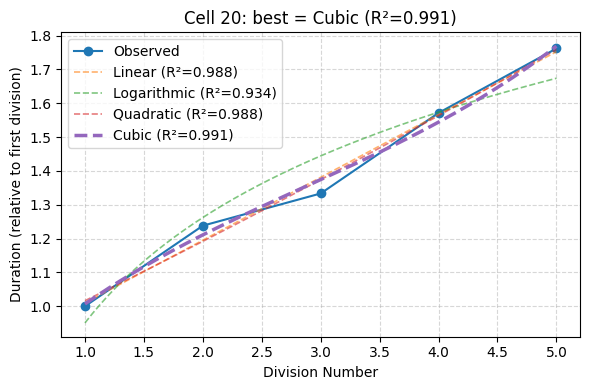

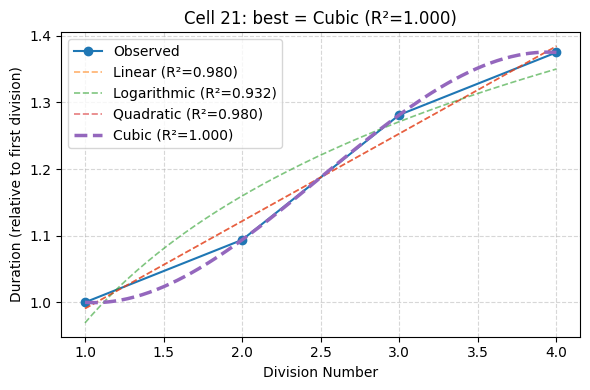

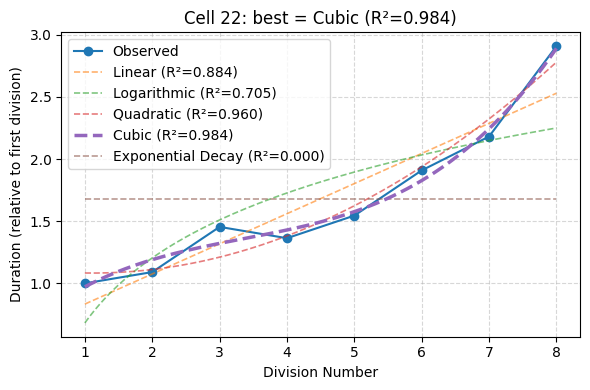

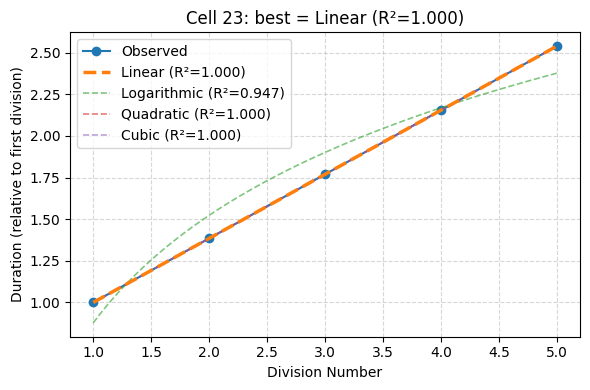

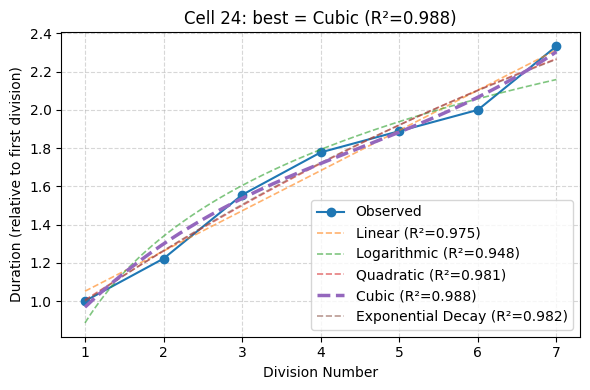

No fitted models for cell 25, too few points


In [210]:
def plot_cell_best_and_all_models(cell_id):
    # observed
    y_series = df_norm[cell_id].dropna()
    if y_series.empty:
        print(f"No data for cell {cell_id}")
        return
    x = y_series.index.astype(float).values
    y = y_series.values

    # models available for this cell
    available = {name: res[cell_id]
                 for name, res in per_cell_fit_results.items()
                 if cell_id in res and np.isfinite(res[cell_id].get("r2", np.nan))}

    if not available:
        print(f"No fitted models for cell {cell_id}, too few points")
        return

    # function lookup
    name_to_func = {
        "Linear": linear,
        "Logarithmic": logarithmic,
        "Quadratic": quadratic,
        "Cubic": cubic,
        "Exponential Decay": exponential_decay,
    }

    # pick best by R²
    best_name, best_res = max(available.items(), key=lambda kv: kv[1]["r2"])

    # plot
    import matplotlib.pyplot as plt
    xfit = np.linspace(x.min(), x.max(), 200)
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, 'o-', label="Observed")

    # plot all models; highlight best
    for name, res in available.items():
        func = name_to_func[name]
        yfit = func(xfit, *res["params"])
        is_best = (name == best_name)
        plt.plot(
            xfit, yfit, '--',
            linewidth=2.5 if is_best else 1.2,
            alpha=1.0 if is_best else 0.6,
            label=f"{name} (R²={res['r2']:.3f})",
            zorder=3 if is_best else 2
        )

    plt.title(f"Cell {cell_id}: best = {best_name} (R²={best_res['r2']:.3f})")
    plt.xlabel("Division Number")
    plt.ylabel("Duration (relative to first division)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

for cid in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]:
    if cid in df_norm.columns:
        plot_cell_best_and_all_models(cid)

fit models to pooled global data

In [211]:
def fit_global_model(df_hours, func, min_points=3, p0=None, maxfev=10000):
    """
    Fit a single model to all points from cells with >= min_points.
    Returns dict with params, R2, included_cells, and the stacked x/y used.
    """
    x_all, y_all, included_cells = [], [], []
    for cell in df_hours.columns:
        y_series = df_hours[cell].dropna()
        if len(y_series) >= min_points:
            x_vals = y_series.index.values.astype(float)
            y_vals = y_series.values
            x_all.extend(x_vals)
            y_all.extend(y_vals)
            included_cells.append(cell)

    x_all = np.asarray(x_all, dtype=float)
    y_all = np.asarray(y_all, dtype=float)

    if x_all.size == 0:
        raise ValueError(f"No cells met min_points={min_points}")

    params, _ = curve_fit(func, x_all, y_all, p0=p0, maxfev=maxfev)
    y_hat = func(x_all, *params)
    R2 = r_squared(y_all, y_hat)

    return {
        "params": params,
        "R2": float(R2),
        "included_cells": included_cells,
        "x_all": x_all,
        "y_all": y_all,
    }

def plot_global_fit(result, func, model_name="Model", color="tab:red"):
    """
    Visualize the global fit: scatter of all included points + fitted curve.
    """
    x_all = result["x_all"]
    y_all = result["y_all"]
    params = result["params"]
    R2 = result["R2"]

    xfit = np.linspace(np.min(x_all), np.max(x_all), 300)
    yfit = func(xfit, *params)

    plt.figure(figsize=(8,5))
    plt.scatter(x_all, y_all, s=20, alpha=0.6, label="Included points", color="black")
    plt.plot(xfit, yfit, "--", lw=2, color=color, label=f"{model_name} fit")
    # params string (short and robust)
    ptxt = ", ".join([f"{p:.3g}" for p in params])
    plt.title(f"{model_name}: R²={R2:.3f} | params=[{ptxt}]")
    plt.xlabel("Division Number")
    plt.ylabel("Duration (relative to first division)")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

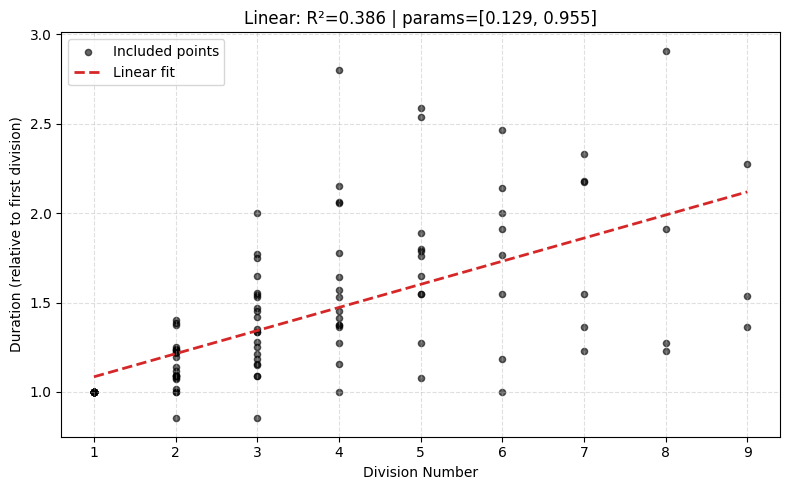

Included cells (linear ≥3): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [212]:
res_lin = fit_global_model(df_norm, linear, min_points=3)
plot_global_fit(res_lin, linear, model_name="Linear")
print("Included cells (linear ≥3):", res_lin["included_cells"])

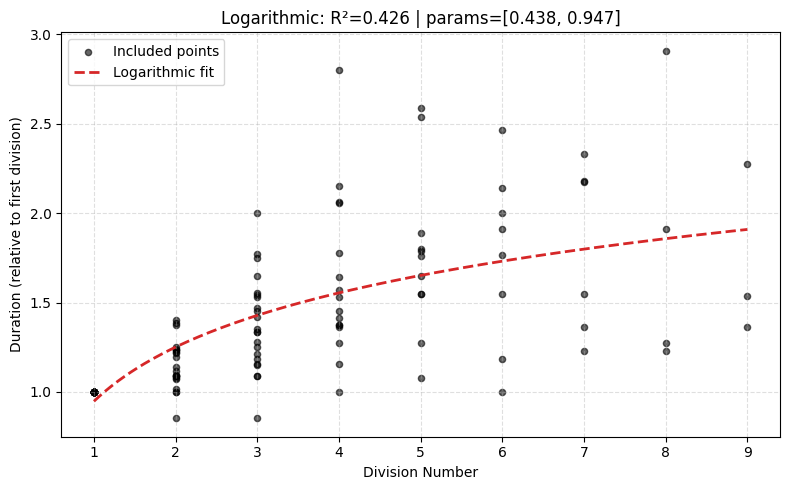

Included cells (logarithmic ≥3): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [213]:
res_lin = fit_global_model(df_norm, logarithmic, min_points=3)
plot_global_fit(res_lin, logarithmic, model_name="Logarithmic")
print("Included cells (logarithmic ≥3):", res_lin["included_cells"])

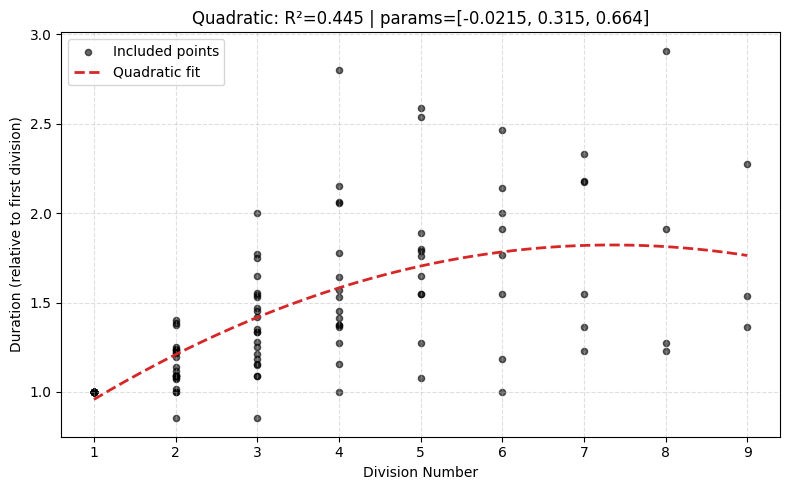

Included cells (quadratic ≥4): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [214]:
res_lin = fit_global_model(df_norm, quadratic, min_points=3)
plot_global_fit(res_lin, quadratic, model_name="Quadratic")
print("Included cells (quadratic ≥4):", res_lin["included_cells"])

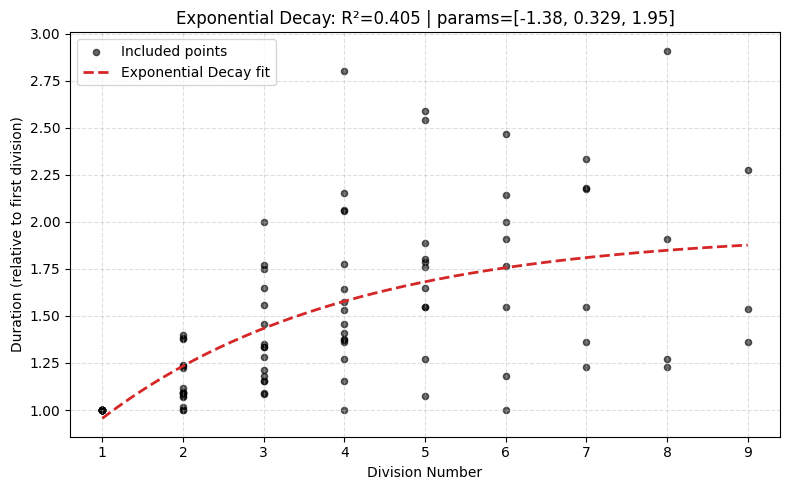

Included cells (exponential decay ≥4): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [215]:
# crude p0: (a, b, c)
y_med = float(np.nanmedian(df_norm.values))
p0_exp = [max(0.1, np.nanmax(df_norm.values) - y_med), 0.3, y_med]

res_exp = fit_global_model(df_norm, exponential_decay, min_points=4, p0=p0_exp)
plot_global_fit(res_exp, exponential_decay, model_name="Exponential Decay")
print("Included cells (exponential decay ≥4):", res_lin["included_cells"])

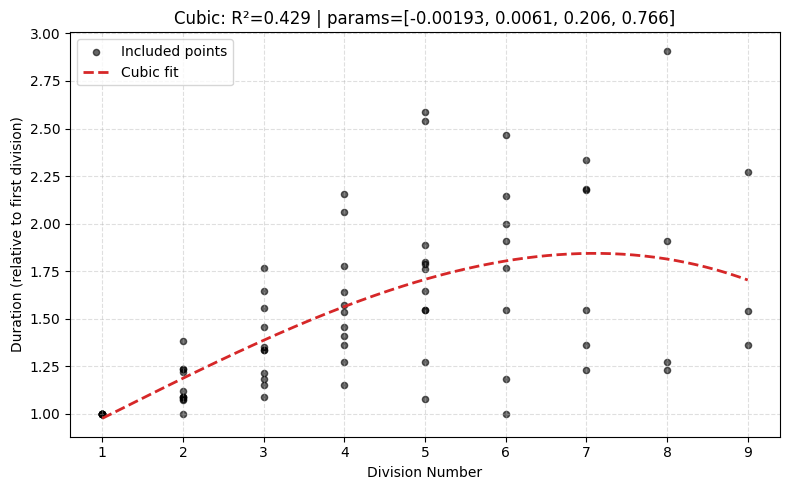

Included cells (cubic ≥5): [12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24]


In [216]:
res_lin = fit_global_model(df_norm, cubic, min_points=5)
plot_global_fit(res_lin, cubic, model_name="Cubic")
print("Included cells (cubic ≥5):", res_lin["included_cells"])

## I think the logarithmic model has the best balance of complexity and performance here

---
Repeat for mudmut

In [ ]:
df_raw = pd.read_excel("mudmut_cellcycle_durations.xlsx", header=None)

df_raw.columns = ['Division'] + list(range(1, df_raw.shape[1]))
df_raw.set_index('Division', inplace=True)

def value_to_hours(val):
    if pd.isna(val):
        return np.nan

    if isinstance(val, (datetime.datetime, pd.Timestamp)):
        return val.hour + val.minute / 60 + val.second / 3600

    if isinstance(val, datetime.time):
        return val.hour + val.minute / 60 + val.second / 3600

    if isinstance(val, (float, int)) and 0 <= val < 1:
        return val * 24

    return np.nan

df_hours = df_raw.applymap(value_to_hours)

df_hours = df_hours.reset_index()

df_hours["Division Number"] = df_hours["Division"].str.extract(r"(\d+)")[0].astype(float)

df_hours = df_hours.dropna(subset=["Division Number"])
df_hours["Division Number"] = df_hours["Division Number"].astype(int)

df_hours = df_hours.set_index("Division Number")
df_hours = df_hours.drop(columns=["Division"])
df_hours

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/2804146572.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hours = df_raw.applymap(value_to_hours)


,1,2,3,4,5,6,7,8,9,10,11,12
Division Number,,,,,,,,,,,,
1,6.083333,3.75,2.250000,2.083333,3.583333,4.333333,4.0,2.750000,2.083333,1.416667,1.833333,1.416667
2,NaN,7.25,2.666667,3.166667,NaN,NaN,NaN,4.083333,3.416667,1.666667,2.250000,2.000000
3,NaN,NaN,NaN,4.416667,NaN,NaN,NaN,NaN,NaN,2.166667,3.000000,2.250000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.333333,4.500000,2.666667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.750000,NaN,3.666667
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.333333,NaN,NaN


In [217]:
# normalize again
df_norm = df_hours.copy()
for cell in df_norm.columns:
    first_div = df_norm[cell].dropna().iloc[0]
    df_norm[cell] = df_norm[cell] / first_div

mean_durations = df_norm.mean(axis=1)
std_durations = df_norm.std(axis=1)

summary = pd.DataFrame({
    "Mean Duration (hrs)": mean_durations,
    "Std Dev (hrs)": std_durations
})

print(summary)

                 Mean Duration (hrs)  Std Dev (hrs)
Division Number                                    
NaN                              NaN            NaN
1.0                         1.000000       0.000000
2.0                         1.142683       0.138052
3.0                         1.382767       0.266242
4.0                         1.625310       0.453170
5.0                         1.768257       0.460320
6.0                         1.751324       0.490354
7.0                         1.805247       0.479797
8.0                         1.830420       0.783225
9.0                         1.724942       0.482382


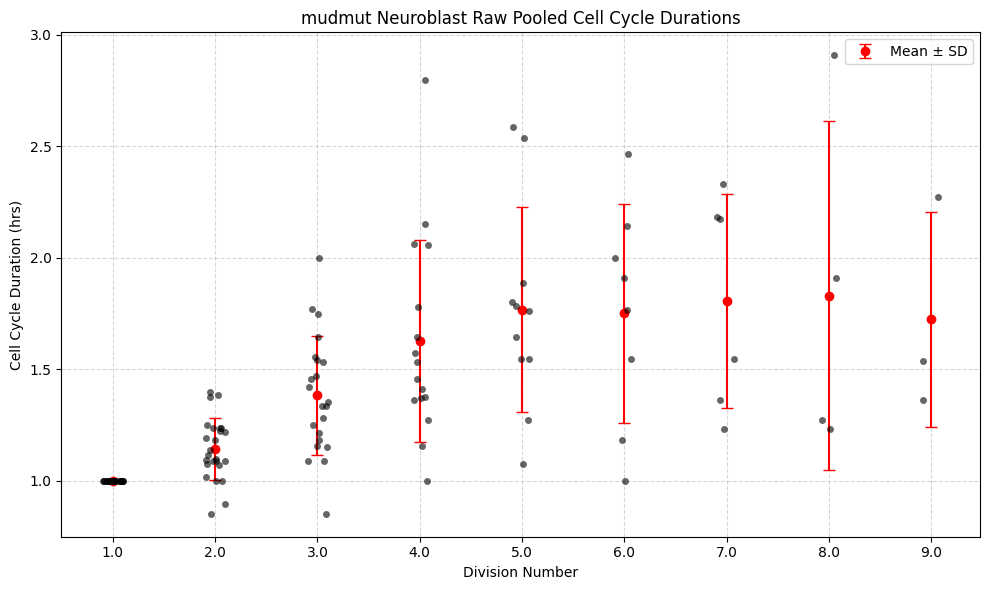

In [218]:
df_long = df_norm.reset_index().melt(id_vars="Division Number", 
                                      var_name="Cell", 
                                      value_name="Duration (hrs)")
df_long = df_long.dropna()

summary = df_long.groupby("Division Number")["Duration (hrs)"].agg(["mean", "std"])

division_order = sorted(df_long["Division Number"].unique())

x_positions = list(range(len(division_order)))
mean_values = summary.loc[division_order, "mean"]
std_values = summary.loc[division_order, "std"]

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long, x="Division Number", y="Duration (hrs)",
              jitter=True, alpha=0.6, color='black', order=division_order)
plt.errorbar(x_positions, mean_values, yerr=std_values,
             fmt='o', color='red', capsize=4, label="Mean ± SD")

plt.title("mudmut Neuroblast Raw Pooled Cell Cycle Durations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Division Number")
plt.ylabel("Cell Cycle Duration (hrs)")
plt.legend()
plt.tight_layout()
plt.show()

In [219]:
from collections import defaultdict

per_cell_fit_results = defaultdict(dict)

for cell in df_norm.columns:
    y = df_norm[cell].dropna()
    x = y.index.astype(float)
    y = y.values

    if len(x) >= 3: # enough points to fit 2 parameter models without default R^2 being 1
        for model_name, func in [("Linear", linear), ("Logarithmic", logarithmic)]:
                try:
                    params, _ = curve_fit(func, x, y)
                    y_pred = func(x, *params)
                    r2 = r_squared(y, y_pred)
                    per_cell_fit_results[model_name][cell] = {
                        "params": params,
                        "r2": r2
                    }
                    continue
                except:
                    continue

    if len(x) >=4: # enough points to fit quadratic, exponential decay, and cubic
        for model_name, func in [("Quadratic", quadratic), ("Exponential Decay", exponential_decay), ("Cubic", cubic)]:
            try:
                params, _ = curve_fit(func, x, y)
                y_pred = func(x, *params)
                r2 = r_squared(y, y_pred)
                per_cell_fit_results[model_name][cell] = {
                    "params": params,
                    "r2": r2
                }
            except:
                continue

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096624.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y)
/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/62096

No fitted models for cell 1, too few points
No fitted models for cell 2, too few points


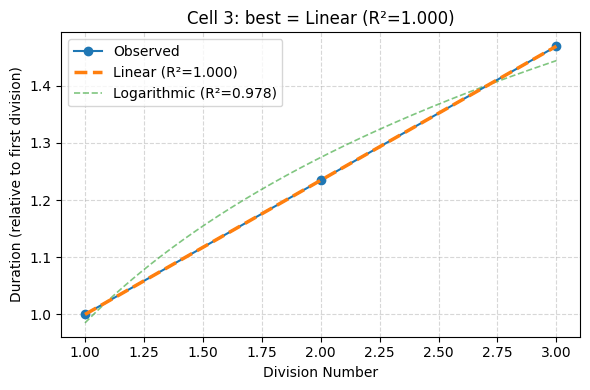

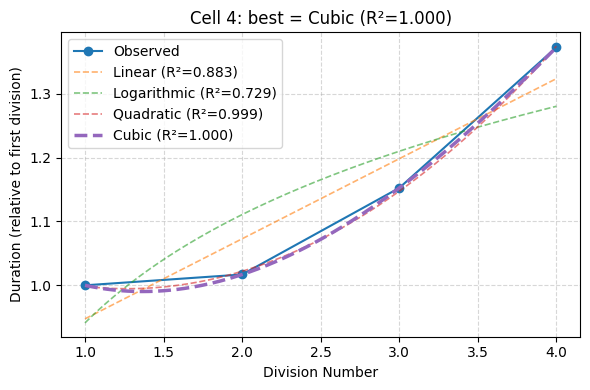

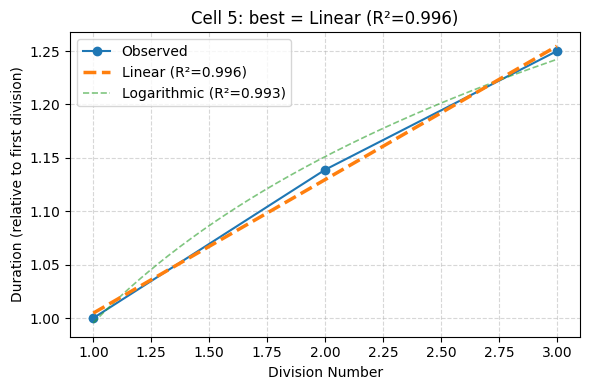

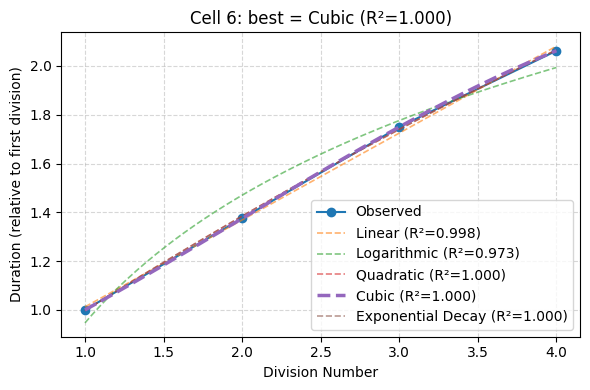

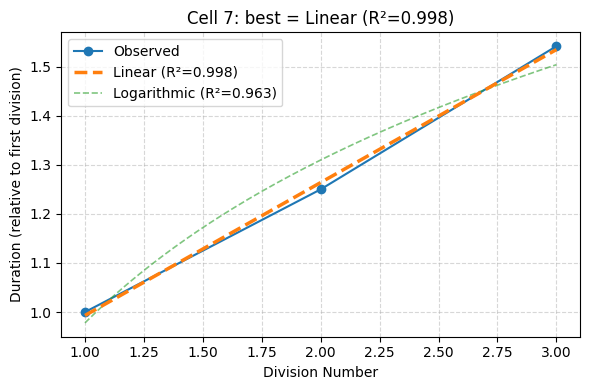

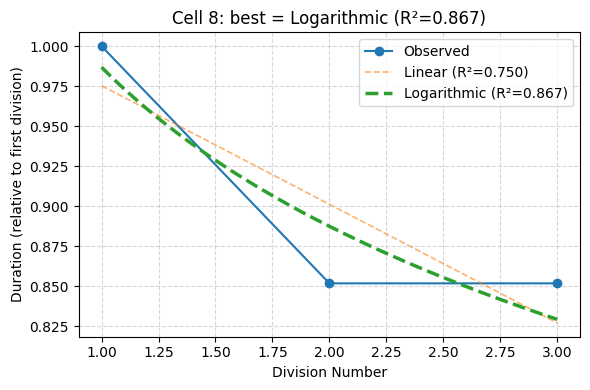

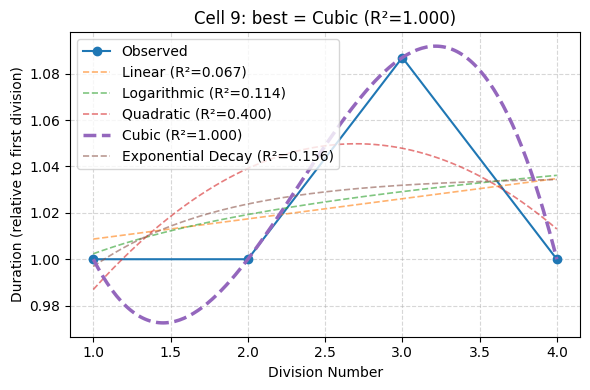

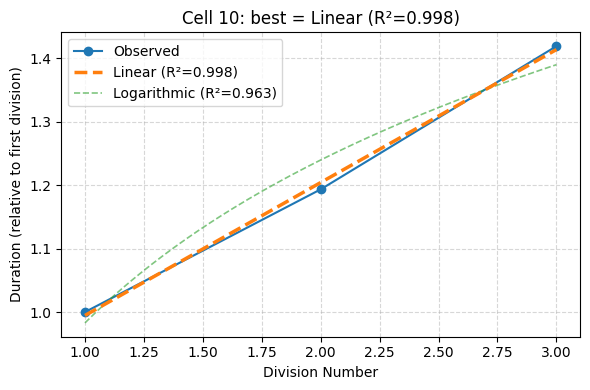

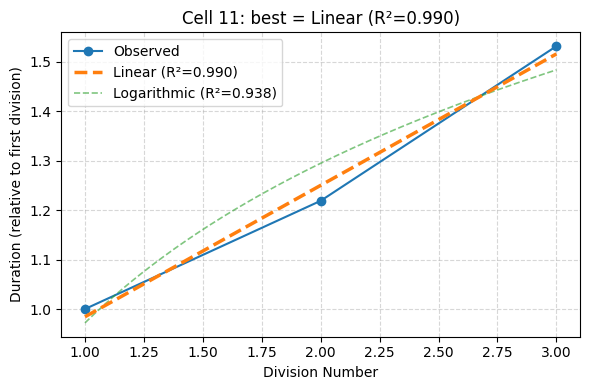

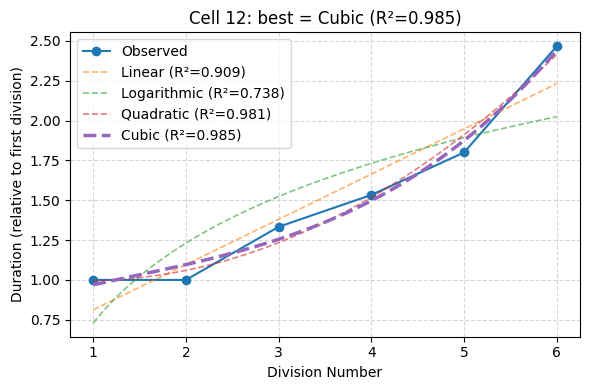

In [220]:
for cid in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    if cid in df_norm.columns:
        plot_cell_best_and_all_models(cid)

global fits:

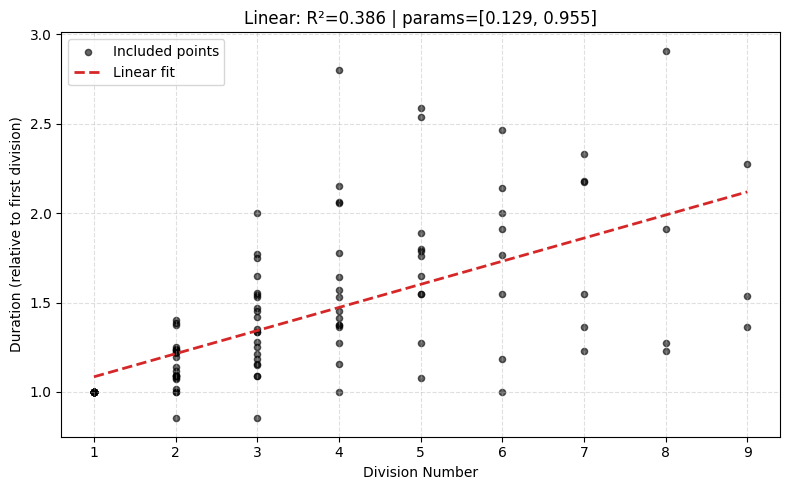

Included cells (linear ≥3): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [221]:
res_lin = fit_global_model(df_norm, linear, min_points=3)
plot_global_fit(res_lin, linear, model_name="Linear")
print("Included cells (linear ≥3):", res_lin["included_cells"])

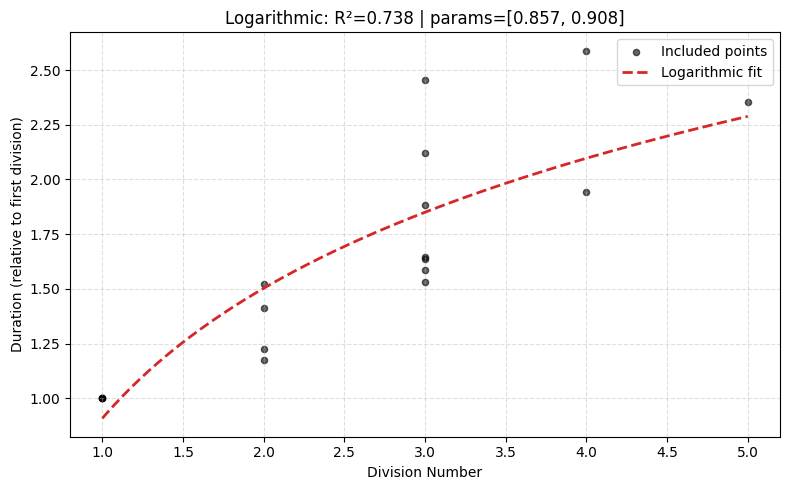

Included cells (logarithmic ≥3): [4, 10, 11, 12]


In [197]:
res_lin = fit_global_model(df_norm, logarithmic, min_points=3)
plot_global_fit(res_lin, logarithmic, model_name="Logarithmic")
print("Included cells (logarithmic ≥3):", res_lin["included_cells"])

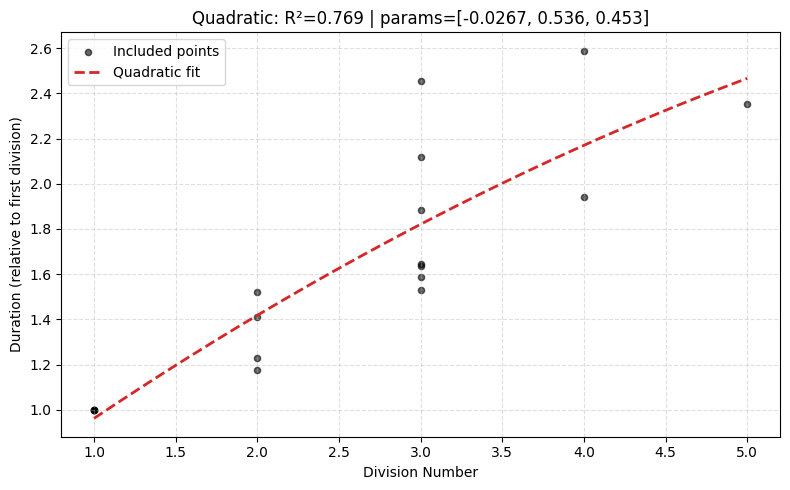

Included cells (quadratic ≥4): [4, 10, 11, 12]


In [198]:
res_lin = fit_global_model(df_norm, quadratic, min_points=3)
plot_global_fit(res_lin, quadratic, model_name="Quadratic")
print("Included cells (quadratic ≥4):", res_lin["included_cells"])

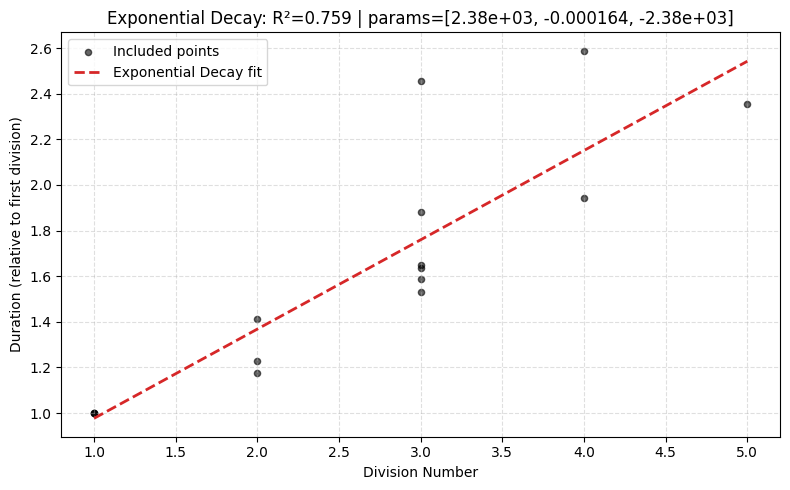

Included cells (exponential decay ≥4): [4, 10, 11, 12]


In [199]:
# crude p0: (a, b, c)
y_med = float(np.nanmedian(df_norm.values))
p0_exp = [max(0.1, np.nanmax(df_norm.values) - y_med), 0.3, y_med]

res_exp = fit_global_model(df_norm, exponential_decay, min_points=4, p0=p0_exp)
plot_global_fit(res_exp, exponential_decay, model_name="Exponential Decay")
print("Included cells (exponential decay ≥4):", res_lin["included_cells"])

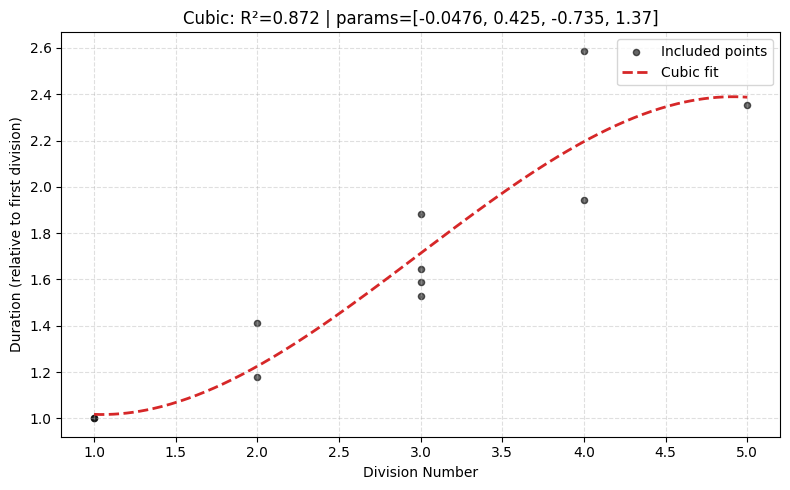

Included cells (cubic ≥5): [10, 12]


In [200]:
res_lin = fit_global_model(df_norm, cubic, min_points=5)
plot_global_fit(res_lin, cubic, model_name="Cubic")
print("Included cells (cubic ≥5):", res_lin["included_cells"])

### with 4 cells it is hard to say anything conclusive imo